In [1]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

In [2]:
# input
model_checkpoint = "experiments/dataaug/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/ganspace/dataaug_bn_default_epoch=774"

In [3]:
model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

GAN(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample(scale_fac

In [4]:
@th.no_grad()
def get_inner_act(model, n_samples=10000, layer="linear"):
    z = th.normal(0, 1, size=(n_samples, model.generator.latent_dim), device=model.device)
    l = model.generator.l1(z)
    if layer == "conv-1":
        l = l.view(l.shape[0],  model.generator.init_channels,
                            model.generator.init_height,  model.generator.init_width)
        l = model.generator.conv_blocks[0](l)
        l = model.generator.conv_blocks[1](l)
        l = model.generator.conv_blocks[2](l)
        l = l.view(l.shape[0], -1)

    X = np.squeeze(l.detach().cpu().numpy())
    y = np.squeeze(z.detach().cpu().numpy())    
    return X, y

In [5]:
n_samples = 5000
n_time = 5
layer = "linear"
pca_path = os.path.join(save_path, layer, "pca.pkl")


if not os.path.exists(pca_path):
    pca = IncrementalPCA(n_components=4096 if layer == "linear" else 16384)
    os.makedirs(os.path.join(save_path, layer), exist_ok=True)

    for i in range(n_time):
        print("Iteration - ", i+1)
        X, y = get_inner_act(model, n_samples, layer=layer)

        # save the data
        np.save(os.path.join(save_path, layer, f"y{i+1}.npy"), y)
        np.save(os.path.join(save_path, layer, f"X{i+1}.npy"), X)

        pca.partial_fit(X)

    # save the pca
    f = open(pca_path, "wb")
    pickle.dump(pca, f)
    f.close()
else:
    f = open(pca_path, 'rb')
    pca = pickle.load(f)
    f.close()

Iteration -  1
Iteration -  2
Iteration -  3
Iteration -  4
Iteration -  5


In [6]:
# load dataset
X = np.concatenate([np.load(os.path.join(save_path, layer, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(save_path, layer, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
information_gain = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(information_gain >= 0.9)[0][0]

# 
comp = pca.components_[:idx]
mean = pca.mean_

# reconstruction
X_pca = (X - mean).dot(comp.T) 

# resonctruction error
X_rec = X_pca.dot(comp) + mean
np.linalg.norm(X_rec - X) / len(X)

0.09416144987571312


In [7]:
reg = LinearRegression(normalize=True).fit(X_pca, y)
np.linalg.norm(X_pca.dot(reg.coef_.T) - y) / len(X)

0.03432425999407893

(0.0, 100.0)

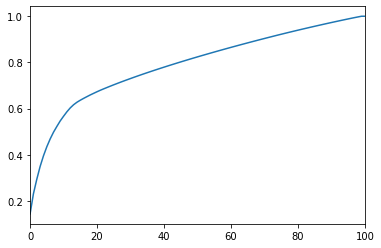

In [8]:
information_gain = np.cumsum(pca.explained_variance_ratio_)
plt.plot(information_gain)
plt.xlim([0, 100])

In [31]:
@th.no_grad()
def explore_principle_direction(idx, U, model, zs, ratios=None):
    
    size = U.shape[1]
    n_samples = zs.shape[0]
    if ratios is None:
        ratios = np.linspace(-0.5, 0.5, 11)
   
    x = th.zeros((size,), device=model.device, dtype=zs.dtype)
    
    imgs = []
    for z in zs:
        for ratio in ratios:
            x[idx] = ratio
            z_ = z + th.matmul(U, x)
            
            img = th.squeeze(model(th.unsqueeze(z_, dim=0)))
            imgs.append(img)
    
    # make grid
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid

In [615]:
zs = th.normal(0, 1, size=(15, model.generator.latent_dim), device=model.device) 
#zs = th.zeros((15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

In [636]:
scale = 70
ratios = np.linspace(-scale, 0, 11)
grid = explore_principle_direction(40, U, model, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

([], [])

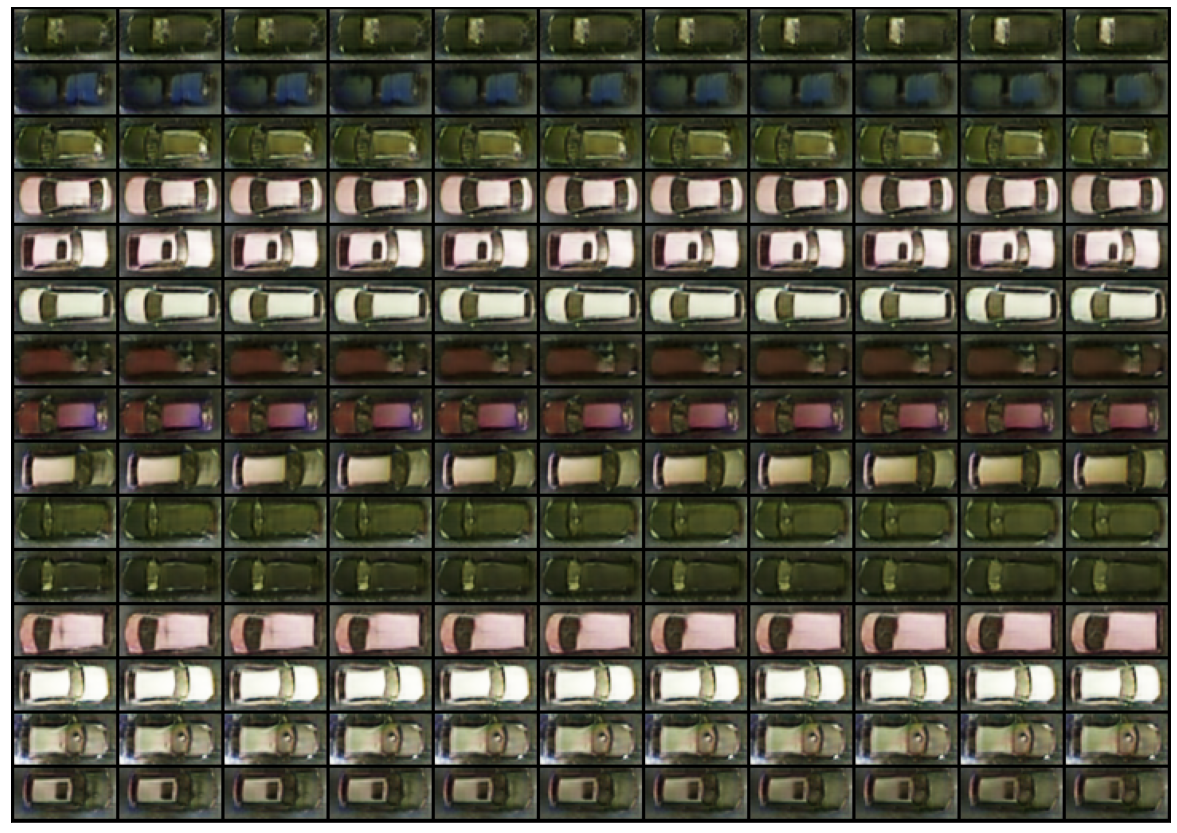

In [637]:
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [ ]:
# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-20, 20] : makes cars white van or green
# dim 2 : ratio [-20, 20] : 
# dim 3 : ratio [-20, 20] : moves car from top to bottom
# dim 4 : ratio [-30 , 30] : 
# dim 5 : ratio [-40, 40] : car becomes red or gets strips on top
# dim 6 : ratio [-30, 0] : makes car blue
# dim 7 : ratio [-50, 50] : 
# dim 9 : ratio [-20, 20] : makes image brighter or darker
# dim 10 : ratio [-40, 0] : adds bright spot and makes car green
# dim 11 : ratio [-40, 40] : makes image darker and green or blue and bright spot on bottom
# dim 12 : ratio [-30, 30] : 
# dim 13 : ratio [-30, 30] : makes image red or green
# dim 14 : ratio [-60, 0] : adds car light front and back
# dim 15 : ratio [-50, 50] : 
# dim 16 : ratio [-60, 60] : lighting direction
# dim 17 : ratio [-50, 50] : changes the aspect ratio of car + lighting on front or back
# dim 20 : ratio [-40, 40] : twists the car and rotates little bit and adds light spot
# dim 25 : ratio [-70, 70] : makes car green or red and add bright spot on left or right
# dim 44 : ratio [-100, 50] : bending the car